In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

import sklearn.preprocessing as preprocessing

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data_total = data.copy()
print('Number of dayads', data.shape)
data.head()

Number of dayads (146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


# 1. Observation and clean of the data

In [3]:
print('Number of diad: ', len(data))
print('Number of players: ', len(data.playerShort.unique()))
print('Number of referees: ', len(data.refNum.unique()))

Number of diad:  146028
Number of players:  2053
Number of referees:  3147


## 1.1. Missing values

In [4]:
complete = len(data.dropna())
all_ = len(data_total)
print('Number of row with complete data: {} ({:.3f}%)'.format(complete, (complete/all_ ) * 100 ))
print('Number of row with missing data: {} ({:.3f}%)'.format(all_-complete, (all_ -complete)/all_  * 100 ))


Number of row with complete data: 115457 (79.065%)
Number of row with missing data: 30571 (20.935%)


### Where are the missing values ?

In [5]:
def find_col_nan(d):
    col = []
    for c in d.columns:
        if d[c].isnull().any():
            col = np.append(col, c)
    return col        

In [6]:
missing_col = find_col_nan(data)
missing_col

array(['height', 'weight', 'position', 'photoID', 'rater1', 'rater2',
       'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], 
      dtype='<U32')

To clean the data, we will go step by step:
    - First of all we have to clean all dayads that don't have any rating, because those dayads are uneseful for our problem.
    - Then we will look again which columns contains missing values and how to deal with them

In [7]:
data = data[ ~data.rater1.isnull() & ~data.rater2.isnull()]
print('Number of row with the 2 ratings {} ({:.3f}%)'.format(len(data), len(data)/len(data_total) * 100))
onlyOne = data[ ~data.rater1.isnull() ^ ~data.rater2.isnull()]
print('Number of row with only one ratings {} ({:.3f}%)'.format(len(onlyOne), len(onlyOne)/len(data_total) * 100))


Number of row with the 2 ratings 124621 (85.340%)
Number of row with only one ratings 0 (0.000%)


Check now how many incomplete dayads our data contains now

In [8]:
complete = len(data.dropna())
all_ = len(data)
print("After removing data without rating:")
print("-----------------------------------")
print('Number of row with complete data: {} ({:.3f}%)'.format(complete, (complete/all_ ) * 100 ))
print('Number of row with missing data: {} ({:.3f}%)'.format(all_-complete, (all_ -complete)/all_  * 100 ))

After removing data without rating:
-----------------------------------
Number of row with complete data: 115457 (92.647%)
Number of row with missing data: 9164 (7.353%)


Let's check again the columns with missing values

In [9]:
missing_col = find_col_nan(data)
missing_col

array(['height', 'weight', 'position', 'Alpha_3', 'meanIAT', 'nIAT',
       'seIAT', 'meanExp', 'nExp', 'seExp'], 
      dtype='<U32')

We only 7.4% of incomplete dayads. Let's try to replace the nan in heights and weights with the median

In [10]:
# replace no height and weight with the mean value
median_height = np.median(data['height'].dropna())
median_weight = np.median(data['weight'].dropna())
data['height'] = data['height'].fillna(value=median_height)
data['weight'] = data['weight'].fillna(value=median_weight)

In [11]:
complete = len(data.dropna())
all_ = len(data)
print("After removing data without rating:")
print("-----------------------------------")
print('Number of row with complete data: {} ({:.3f}%)'.format(complete, (complete/all_ ) * 100 ))
print('Number of row with missing data: {} ({:.3f}%)'.format(all_-complete, (all_ -complete)/all_  * 100 ))

After removing data without rating:
-----------------------------------
Number of row with complete data: 116014 (93.093%)
Number of row with missing data: 8607 (6.907%)


In [12]:
missing_col = find_col_nan(data)
missing_col

array(['position', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp',
       'nExp', 'seExp'], 
      dtype='<U32')

The incomplete row only represent 7%.
We will check if 2 dayads with referee of the same country, one with complete data and an other one with missing IAT and Exp info exist. In that case it is easy to complete those information

In [13]:
missing_col_test = ['meanIAT', 'nIAT', 'seIAT', 'meanExp',
       'nExp', 'seExp']
exist = False
def checkMissingTest(df):
    for col in missing_col_test:
        nbr_dayads = len(df)
        nbr_noNaN = len(df.dropna(subset=[col]))
        if nbr_dayads > nbr_noNaN &  nbr_noNaN > 0:
            exist = True
            print('There exist valid data for ', df.Alpha_3)
grouped = pd.groupby(data, by='refCountry').apply(checkMissingTest)      
print('Does it exist 2 dayads of same country, one with info on test and one with missing values in test ?: ', exist)

Does it exist 2 dayads of same country, one with info on test and one with missing values in test ?:  False


Look at how many player don't have a position

In [14]:
complete = len(data.dropna(subset=['position']))
all_ = len(data)
print("After removing data without rating:")
print("-----------------------------------")
print('Number of row with complete data: {} ({:.3f}%)'.format(complete, (complete/all_ ) * 100 ))
print('Number of row with missing data: {} ({:.3f}%)'.format(all_-complete, (all_ -complete)/all_  * 100 ))

After removing data without rating:
-----------------------------------
Number of row with complete data: 116160 (93.211%)
Number of row with missing data: 8461 (6.789%)


For those player we will try to assign them a new position called 'Joker'

In [15]:
data.position = data.position.fillna('Joker')

In [16]:
missing_col = find_col_nan(data)
missing_col

array(['Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], 
      dtype='<U32')

In [17]:
complete = len(data.dropna())
all_ = len(data)
print("After removing data without rating:")
print("-----------------------------------")
print('Number of row with complete data: {} ({:.3f}%)'.format(complete, (complete/all_ ) * 100 ))
print('Number of row with missing data: {} ({:.3f}%)'.format(all_-complete, (all_ -complete)/all_  * 100 ))

After removing data without rating:
-----------------------------------
Number of row with complete data: 124468 (99.877%)
Number of row with missing data: 153 (0.123%)


The remaining NaN represent only 0.1% and concern the columns about country and the test in those country which are hard to guess. So we deceide to drop the remaining dayad with NaN

In [18]:
data = data.dropna()
find_col_nan(data)


[]

## 1.2. Handling different ratings (rater1 vs rater2)
- We check if there is player with only one rating
- We also check if one rater always give the same rate to the same player
- Now we need to take one single rating for each row. We'll need to investigate a bit more the different rating




    

Is there players with only one rating?

In [19]:
(data.rater1.isnull() | data.rater2.isnull()).any()

False

Are the raters consistent?

In [20]:
def areRaterConsistent(d):
    for playerID in d.playerShort.unique():
  
        player = d[d.playerShort == playerID]
        rater1 = player.rater1.unique()
        rater2 = player.rater2.unique()
        if len(rater1) >1 or len(rater2) > 1:
            return False
    return True  

In [21]:
print("Are the rater consistent: ",areRaterConsistent(data))

Are the rater consistent:  True


### Investigation on the raters

Values of the rating

In [22]:
data.rater1.unique()

array([ 0.25,  0.75,  0.  ,  1.  ,  0.5 ])

Are the raters always agree

In [23]:
print("percentage of players with different ratings: ", len(data[data['rater1'] != data['rater2']])*100 / len(data), "%")

percentage of players with different ratings:  23.18989619821962 %


Let's show some plost to visualize when the rater differe

In [24]:
len(data)

124468

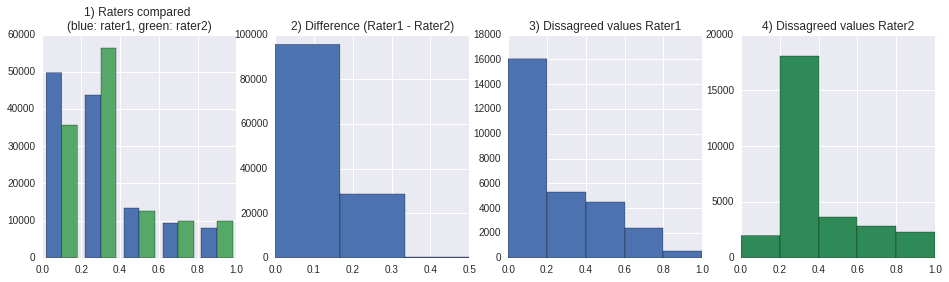

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].hist([data['rater1'], data['rater2']], bins=5)
ax[0].set_title("1) Raters compared \n(blue: rater1, green: rater2)")

ax[1].hist(abs(data['rater1'] - data['rater2']), bins=3)
ax[1].set_title("2) Difference (Rater1 - Rater2)")

dissagree_data = data[data['rater1'] != data['rater2']]
ax[2].hist(dissagree_data['rater1'], bins=5)
ax[2].set_title("3) Dissagreed values Rater1")

ax[3].hist(dissagree_data['rater2'], bins=5, color='seagreen')
ax[3].set_title("4) Dissagreed values Rater2")

We can see that rater1 and 2 disagree the most when they have to rate "white" people.

We can also see with graph2 that when there disagree it's ony of one category.


Now we will create a new columns: color_skin that will be our label to guess. To convert the values of rater 1 and 2 in one rate, we need to follow some rules that come from the graph:
    1. if rater1 and rater2 are agree, take that value
    2. We can see on graph 4 that when rater2 give 0, usually, rater1 agrees => so when rater2 give 0, we take that value as the color skin
    3. In graph 3, when rater1 give 1, rater2 usually agrees => when rater1 give 1, take that value as the color_skin
    4. In graph 3, we can see that when rater1 rate1 give 0.25, usually rater2 agrees => take rater1
    5. choose at random between both values
   
   
Then we can drop the features rater1, rater2 since we don't need them anymore    
    
    

In [26]:
data['color_rating'] = -1

In [27]:
def color_skin_rules(row):
    #Rule 1
    if row.rater1 == row.rater2:
        return row.rater1
    #Rule2    
    elif row.rater2 == 0:
        return 0
    #Rule 3
    elif row.rater1 == 1:
        return 1
    #Rule 4
    elif row.rater1 == 0.25:
        return 0.25
    else: 
        return np.random.choice([row.rater1, row.rater2])
data.color_rating = data.apply(color_skin_rules, axis=1)


And now make the color_rating categorical:

In [28]:
categorical_dict = {0: 1, 0.25: 2, 0.5: 3, 0.75: 4, 1: 5 }
data['color_rating'] = data.apply(lambda row: categorical_dict[row['color_rating']]
, axis=1).astype('category')

In [29]:
data = data.drop(['rater1', 'rater2'], axis=1)

In [30]:
data_cleaned=data.copy()
data_cleaned.to_csv('CrowdstormingDataJuly1st_preprocessed.csv')
data_cleaned.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,color_rating
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,2
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,4
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,5


# Aggregate the data
One solution is to group the data by player name. Then we need to find a solution to correctly group the remaining features:
    - club: we have to check if a player appear in 2 different club (in case of a transfer during the winter mercato ) or if the transfer are not taking into account. (-> one (several) hot encoding. or majority dyads per club)
    - leagueCountry: same as club
    - position: test if the player as different -> position with the majority of game? 
    - photoID: drop that information, the id is unique -> not relevant for our classification probleme
    - refNum: replace with the total of unique refs
    - refCountry: same as refNum
    - Alpha_3: remove: redundant information since it correspond to the refCountry
    - meanIAT: make new features
        - take mean 
        - take weighted mean (weight with nIAT)
        - take weighted mean (weight with game numers)
    - meanExp: same as IAT
    - seAIT: 
    - seExp:

First do some checks

In [31]:
clubUnique = True
leagueUnique = True
positionUnique = True
def checkFunction(player):

    #check if the club is unique for one player
    if len(player.club.unique()) > 1:
        clubUnique = False
        print(player.player, 'plays for more than one team: ', player.club.unique())
    #check if the leagueCountry is unique
    if len(player.leagueCountry.unique()) > 1:
        leagueUnique = False
        print(player.player, 'plays for more than one league: ', player.leagueCountry.unique())
    #check if the position is unique
    if len(player.position.unique()) > 1:
        positionUnique = False
        print(player.player, 'plays for more than one position: ', player.position.unique())
           
data_group = pd.groupby(data_cleaned, by=data_cleaned.playerShort).apply(checkFunction)
print("Is the club for a player unique? ", clubUnique)
print("Is the league for a player unique? ", leagueUnique)
print("Is the position for a player unique? ", positionUnique)

Is the club for a player unique?  True
Is the league for a player unique?  True
Is the position for a player unique?  True


Then aggregate

In [32]:
def meanCards(row, test):
    total_cards =   row.yellowCards + row.yellowReds + row.redCards     
    if total_cards == 0:
            return 0
    else:
        if(test == 'IAT'):
            return (row.meanIAT * row.yellowCards) + (row.meanIAT * row.yellowReds)  \
             + (row.meanIAT * row.redCards) / total_cards
        else:  
            return (row.meanExp * row.yellowCards) + (row.meanExp * row.yellowReds)  \
             + (row.meanExp * row.redCards) / total_cards
            

def aggreagtion(df):
    first_entry = df.head(1)
    # new aggregation entry
    new_entry = first_entry.copy()
    
    #sum of the info about the games
    new_entry.games = df.games.sum()
    new_entry.victories = df.victories.sum()
    new_entry.ties = df.ties.sum()
    new_entry.defeats = df.defeats.sum()
    new_entry.goals = df.goals.sum()
    new_entry.yellowCards = df.yellowCards.sum()
    new_entry.yellowReds = df.yellowReds.sum()
    new_entry.redCards = df.redCards.sum()
    
    #drop photoID and alpha_3
    new_entry.drop('photoID', inplace = True, axis=1)
    new_entry.drop('Alpha_3', inplace = True, axis=1)
    
    #refNum: number of unique ref
    new_entry = new_entry.rename(columns = {'refNum': 'refCount'})
    new_entry.refCount = len(df.refNum.unique())
    
    #refCountry: replace by number of unique country
    new_entry = new_entry.rename(columns = {'refCountry': 'refCountryCount'})
    new_entry.refCountryCount = len(df.refCountry.unique())
    
    #==Mean of the test result ===
    #- take mean 
    #- take weighted mean (weight with nIAT)
    #- take weighted mean (weight with game numers)
    
    new_entry.meanIAT = df.meanIAT.mean()
    new_entry.meanExp = df.meanExp.mean()
    
    new_entry['meanIAT_nIAT'] = (df.meanIAT * df.nIAT).sum() / df.nIAT.sum() 
    new_entry['meanExp_nExp'] = (df.meanExp * df.nExp).sum() / df.nExp.sum()
    
    new_entry['meanIAT_GameNbr'] = (df.meanIAT * df.games).sum() / df.games.sum()
    new_entry['meanExp_GameNbr'] = (df.meanExp * df.games).sum() / df.games.sum()
    
    new_entry['meanIAT_cards'] = df.apply(lambda r : meanCards(r, test='IAT'), axis = 1)   
    new_entry['meanExp_cards'] = df.apply(lambda r: meanCards(r, test = 'Exp'), axis = 1)
    
    #????????????????????? DROP nIART nExp or NOT ?????????????????????????????
    new_entry.drop('nIAT', inplace = True, axis=1)
    new_entry.drop('nExp', inplace = True, axis=1)
    
    # standard error = standard deviation / sqrt(n)
    #mean of the standard deviation: mean of the variance and then sqrt
    varIAT = (df.seIAT * np.sqrt(df.nIAT)) ** 2
    new_entry.seIAT = np.sqrt(np.mean(varIAT))/ np.sqrt(df.nIAT)
    varExp = (df.seExp * np.sqrt(df.nExp)) ** 2
    new_entry.seExp = np.sqrt(np.mean(varExp))/ np.sqrt(df.nExp)
    return new_entry
 
data_agregated = pd.groupby(data_cleaned, by="playerShort").apply(aggreagtion)
data_agregated

,,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
playerShort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,654,247,179,228,9,19,0,0,166,37,0.346459,0.001505,0.494575,0.009691,1,0.328409,0.367721,0.333195,0.400637,0.000000,0.000000
aaron-hunt,745,aaron-hunt,Aaron Hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,336,141,73,122,62,42,0,1,99,25,0.348818,0.000834,0.449220,0.003823,2,0.329945,0.441615,0.341438,0.380811,0.000000,0.000000
aaron-lennon,746,aaron-lennon,Aaron Lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,412,200,97,115,31,11,0,0,101,28,0.345893,0.001113,0.491482,0.006350,2,0.328230,0.365628,0.332389,0.399459,0.000000,0.000000
aaron-ramsey,747,aaron-ramsey,Aaron Ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,260,150,42,68,39,31,0,1,104,37,0.346821,0.003786,0.514693,0.015240,1,0.327775,0.412859,0.336638,0.433294,0.000000,0.000000
abdelhamid-el-kaoutari,4418,abdelhamid-el-kaoutari,Abdelhamid El-Kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,124,41,40,43,1,8,4,2,37,11,0.331600,0.000474,0.335587,0.001745,2,0.338847,0.379497,0.331882,0.328895,0.000000,0.000000
abdou-traore_2,2305,abdou-traore_2,Abdou Traoré,Girondins Bordeaux,France,17.01.1988,180.0,74.0,Right Midfielder,97,41,23,33,3,11,1,0,42,13,0.320079,0.000889,0.296562,0.002659,4,0.332117,0.366031,0.327985,0.317247,0.000000,0.000000
abdoulaye-diallo_2,47,abdoulaye-diallo_2,Abdoulaye Diallo,Stade Rennes,France,30.03.1992,189.0,80.0,Goalkeeper,24,8,8,8,0,0,0,0,20,5,0.341625,0.000186,0.400818,0.000774,4,0.337572,0.361394,0.343556,0.428271,0.000000,0.000000
abdoulaye-keita_2,4423,abdoulaye-keita_2,Abdoulaye Keita,Girondins Bordeaux,France,19.08.1990,188.0,83.0,Goalkeeper,3,0,1,2,0,0,0,0,2,2,0.355406,0.000249,0.417225,0.001029,4,0.341567,0.363284,0.348498,0.390184,0.000000,0.000000
abdoulwhaid-sissoko,4424,abdoulwhaid-sissoko,Abdoulwhaid Sissoko,Stade Brest,France,20.03.1990,180.0,68.0,Defensive Midfielder,121,34,25,62,3,21,0,2,56,3,0.348178,0.000163,0.429630,0.000674,5,0.344426,0.404517,0.344130,0.402314,0.000000,0.000000


In [33]:
data_agregated.to_csv('CrowdstormingDataJuly1st_aggregated.csv')

# Encode the data for the Random Forest
The Random Forest can only handle integer or float attributes, so we have to encode the string attributes as numbers.

In [34]:
def encode(data_frame, inplace=False):
    """
    encodes the non numerical columns with a LabelEncoder
    returns a new data_frame if inplace = False, otherwise changes the given data_frame
    """
    _df = data_frame if inplace else data_frame.copy()
    le = pp.LabelEncoder() # encoder
    for col_name in _df.columns:
        if _df.dtypes[col_name] == 'O':
            _df[col_name] = le.fit_transform(_df[col_name])
            print("encoded", col_name)
    return _df

In [35]:
data_cleaned_encoded = encode(data_cleaned, inplace=False)
data_cleaned_encoded.head(1)

encoded playerShort
encoded player
encoded club
encoded leagueCountry
encoded birthday
encoded position
encoded photoID
encoded Alpha_3


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,color_rating
0,901,1046,70,3,1382,177.0,72.0,0,1,0,0,1,0,0,0,0,1532,1,1,59,0.326391,712.0,0.000564,0.396,750.0,0.002696,2


In [36]:
data_cleaned_aggregated_encoded = encode(data_agregated, inplace=False)
data_cleaned_aggregated_encoded.head(1)

encoded playerShort
encoded player
encoded club
encoded leagueCountry
encoded birthday
encoded position


,,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
playerShort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,5,0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,166,37,0.346459,0.001505,0.494575,0.009691,1,0.328409,0.367721,0.333195,0.400637,0.0,0.0


In [37]:
data_cleaned_encoded.to_csv('CrowdstormingDataJuly1st_preprocessed_encoded.csv')
data_cleaned_aggregated_encoded.set_index("playerShort").to_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')

In [38]:
data_cleaned_aggregated_encoded.set_index("playerShort").head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
playerShort,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,166,37,0.346459,0.001505,0.494575,0.009691,1,0.328409,0.367721,0.333195,0.400637,0.0,0.0
1,393,91,2,176,183.0,73.0,0,336,141,73,122,62,42,0,1,99,25,0.348818,0.000834,0.449220,0.003823,2,0.329945,0.441615,0.341438,0.380811,0.0,0.0
2,394,83,0,719,165.0,63.0,11,412,200,97,115,31,11,0,0,101,28,0.345893,0.001113,0.491482,0.006350,2,0.328230,0.365628,0.332389,0.399459,0.0,0.0
3,395,6,0,1199,178.0,76.0,3,260,150,42,68,39,31,0,1,104,37,0.346821,0.003786,0.514693,0.015240,1,0.327775,0.412859,0.336638,0.433294,0.0,0.0
4,396,51,1,758,180.0,73.0,1,124,41,40,43,1,8,4,2,37,11,0.331600,0.000474,0.335587,0.001745,2,0.338847,0.379497,0.331882,0.328895,0.0,0.0
